In [23]:

import tensorflow
tensorflow.test.gpu_device_name()

2022-05-28 11:21:18.425888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:21:18.426522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:21:18.426981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:21:18.427504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:21:18.427892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

'/device:GPU:0'

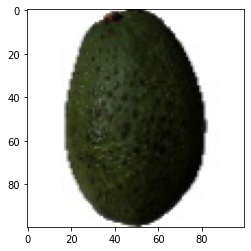

In [24]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('../input/fruit360-dataset-cnn/Fruit-360/Test/Avocado/174_100.jpg', 'r')


imshow(np.asarray(pil_im))

In [25]:

from tensorflow.keras import backend as K
from time import time

# DATA SOURCE --------------------------------------------------

train_data_dir = '../input/fruit360-dataset-cnn/Fruit-360/Training'
validation_data_dir = '../input/fruit360-dataset-cnn/Fruit-360/Validation'
test_data_dir = '../input/fruit360-dataset-cnn/Fruit-360/Test'
image_size = (150, 150)
batch_size = 32

In [26]:
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    image_size=image_size,
    shuffle=True,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 4554 files belonging to 10 classes.
Found 1594 files belonging to 10 classes.
Found 219 files belonging to 10 classes.


# **Image Augmentation**

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.2,
        horizontal_flip = True)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)

train_ds_augmentation = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_ds_augmentation = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 4554 images belonging to 10 classes.
Found 1594 images belonging to 10 classes.


# **The Model**

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling                    

# MODEL --------------------------------------------------

model = Sequential()
model.add(Rescaling(scale=(1./127.5),offset=-1, input_shape=(150, 150, 3)))

# -------------------APRENDIZAJE DE CARACTERISTICAS (CAPAS OCULTAS)-------------------------
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# -------------------EMPIEZA A CLASIFICAR-------------------------
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 148, 148, 8)       224       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 8)         584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 4)         292       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 17, 17, 4)        

In [29]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [30]:
# TRAINING --------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=4, restore_best_weights=True)

history= model.fit(
         train_ds,
         epochs=epochs,
         validation_data = validation_ds,
         callbacks = [es]
)


Epoch 1/200
143/143 [==============================] - 7s 42ms/step - loss: 1.9762 - accuracy: 0.2361 - val_loss: 1.3164 - val_accuracy: 0.6393
Epoch 2/200
143/143 [==============================] - 6s 39ms/step - loss: 1.1411 - accuracy: 0.5569 - val_loss: 0.6566 - val_accuracy: 0.7522
Epoch 3/200
143/143 [==============================] - 6s 40ms/step - loss: 0.7889 - accuracy: 0.7005 - val_loss: 0.5812 - val_accuracy: 0.7936
Epoch 4/200
143/143 [==============================] - 5s 34ms/step - loss: 0.6186 - accuracy: 0.7655 - val_loss: 0.4906 - val_accuracy: 0.8802
Epoch 5/200
143/143 [==============================] - 6s 39ms/step - loss: 0.5198 - accuracy: 0.7894 - val_loss: 0.5677 - val_accuracy: 0.8181
Epoch 6/200
143/143 [==============================] - 5s 36ms/step - loss: 0.4659 - accuracy: 0.8177 - val_loss: 0.4664 - val_accuracy: 0.8538
Epoch 7/200
143/143 [==============================] - 6s 41ms/step - loss: 0.4353 - accuracy: 0.8274 - val_loss: 0.4802 - val_accuracy:

In [31]:
# SAVING --------------------------------------------------

model.save("mimodelo.h5")

#  **Evaluación de resultados**

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       143
           1     0.7530    1.0000    0.8591       125
           2     1.0000    1.0000    1.0000       154
           3     0.8795    1.0000    0.9359       146
           4     0.9872    0.8603    0.9194       179
           5     0.8476    0.9929    0.9145       140
           6     1.0000    1.0000    1.0000       160
           7     0.9512    0.8864    0.9176       176
           8     1.0000    0.7664    0.8677       214
           9     1.0000    1.0000    1.0000       157

    accuracy                         0.9398      1594
   macro avg     0.9418    0.9506    0.9414      1594
weighted avg     0.9494    0.9398    0.9397      1594



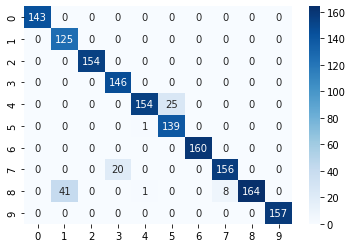

In [32]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

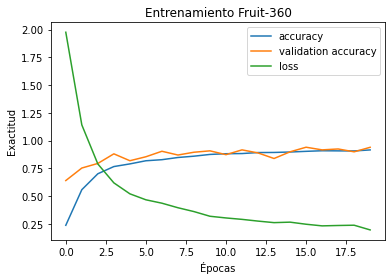

In [33]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento Fruit-360')

plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")

plt.show()

(150, 150, 3)
El vector de salida obtenido:  [[7.6998609e-01 4.9608183e-04 2.2592959e-01 3.9666488e-09 6.6022672e-08
  1.1894828e-09 3.7081529e-11 2.4795290e-06 3.5856031e-03 7.4836315e-08]]
La etiqueta de salida predicha es  0
Ahora dicho con texto: La etiqueta de salida predicha es  Avocado


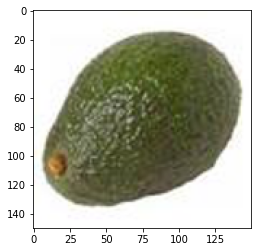

In [34]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['Avocado', 'Banana', 'Blueberry', 'Cocos', 'Kiwi', 'Nectarine', 'Orange', 'Papaya', 'Strawberry', 'Watermelon']
%matplotlib inline

pil_im = Image.open('../input/fruit360-dataset-cnn/Fruit-360/Test/Avocado/foto_nuestra_avocado.jpg', 'r')
im = np.asarray(pil_im.resize((150, 150)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 150x150x3

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

im = im.reshape(1,150,150,3)



print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])




In [35]:
##### PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['Avocado', 'Banana', 'Blueberry', 'Cocos', 'Kiwi', 'Nectarine', 'Orange', 'Papaya', 'Strawberry', 'Watermelon']
%matplotlib inline

for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")

Strawberry -> Strawberry
Cocos -> Cocos
Nectarine -> Nectarine
Orange -> Orange
Orange -> Orange
Strawberry -> Strawberry
Nectarine -> Nectarine
Cocos -> Cocos
Papaya -> Papaya
Banana -> Banana
Papaya -> Papaya
Avocado -> Avocado
Avocado -> Avocado
Strawberry -> Strawberry
Nectarine -> Nectarine
Papaya -> Papaya
Kiwi -> Kiwi
Avocado -> Avocado
Papaya -> Papaya
Cocos -> Papaya ✘
Avocado -> Avocado
Banana -> Banana
Kiwi -> Kiwi
Watermelon -> Watermelon
Avocado -> Avocado
Cocos -> Cocos
Papaya -> Papaya
Nectarine -> Nectarine
Papaya -> Papaya
Orange -> Orange
Blueberry -> Blueberry
Watermelon -> Watermelon
Kiwi -> Kiwi
Watermelon -> Watermelon
Papaya -> Papaya
Orange -> Orange
Nectarine -> Nectarine
Kiwi -> Kiwi
Strawberry -> Strawberry
Kiwi -> Kiwi
Kiwi -> Kiwi
Watermelon -> Avocado ✘
Banana -> Banana
Papaya -> Papaya
Papaya -> Papaya
Nectarine -> Nectarine
Orange -> Orange
Papaya -> Papaya
Banana -> Banana
Cocos -> Cocos
Watermelon -> Watermelon
Watermelon -> Watermelon
Watermelon -> Wa